<a href="https://colab.research.google.com/github/tbacha/DMML2019_Team_Apple/blob/Tarik_/code/Kickstarter_notebook_Team_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
From Ahmad:
I would suggest to try multiple models for classification
and regression and compare them to make your project more
significant. Also focus a bit more on the EDA part and try
to make an interesting analysis with nice visualisations.
There could be interesting questions which could be answered
by your analysis, eg: which category of the projects have a
higher success rate. Also if this data-set was already used
in a kaggle competition, you can also report and compare your
accuracy with the accuracy of the wining team of the
competition in kaggle.
"""

In [0]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [4]:
print("The dataset contains %d observations and %d features." % (df.shape[0], df.shape[1]))

The dataset contains 378661 observations and 15 features.


# Data cleaning
Applying correct data type to time features.

In [5]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

In [6]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

Removing the undefined/live and suspended status.

In [7]:
criteria = df["state"].isin(["failed", "successful", "canceled"])
df = df[criteria]
df.shape

(370454, 15)

Removing the 'goal' and 'pledged' features, since we already have columns with the normalized equivalent in USD.

The 'usd pledged' feature is also removed, because it serves no purpose (there is already a 'usd_pledged_real' feature).

In [0]:
df = df.drop(['goal', 'pledged', 'usd pledged'], axis=1)

we see here a noisy value for "country".

In [9]:
df[(df["backers"]==0) & (df["state"] == 'successful')].head(2)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,2016-04-26 19:46:26,successful,0,"N,0""",5170.0,5000.0
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,2016-04-11 19:29:17,successful,0,"N,0""",5296.0,5000.0


Control of the "null" values

In [10]:
df[pd.isnull(df).any(axis=1)]

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,failed,1,US,100.00,200000.00
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,failed,12,GB,316.05,3224.97
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,failed,5,US,220.00,35000.00


We choose to delete those (country noisy value and null value of name) lines because they represent less than 0.03% of the dataset.

In [11]:
df = df[(df["country"] != 'N,0"') & (df["name"].notnull())]
df.shape

(370219, 12)


For analysis purposes, adding features for the success rate (percentage of goal achieved) as well as the elapsed time.

In [12]:
df["pct_reached"] = round(df["usd_pledged_real"] / df["usd_goal_real"], 2)
df["pct_reached"].head(10)

0    0.00
1    0.08
2    0.00
3    0.00
4    0.07
5    1.05
6    1.20
7    0.02
8    0.07
9    0.10
Name: pct_reached, dtype: float64

In [14]:
df["elapsed_time"] = df["deadline"] - df["launched"]
df["elapsed_time"].head(10)

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
5   34 days 10:21:33
6   19 days 05:29:16
7   44 days 03:54:48
8   34 days 05:45:17
9   29 days 02:04:12
Name: elapsed_time, dtype: timedelta64[ns]

# Exploratory Data Analysis
Only 36% of all projects reached their goal, the rest being either failed or canceled.

Text(0, 0.5, '')

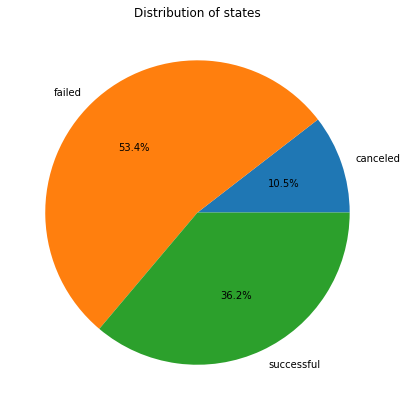

In [15]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")
ax.set_ylabel("")

On average, failed and canceled projects tend to ask for a much higher amount of money than successful ones.

Text(0, 0.5, 'Goal (USD)')

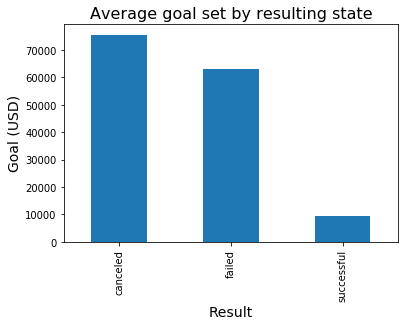

In [16]:
df_goal_state = df.groupby(["state"])["usd_goal_real"].mean()
ax = df_goal_state.plot(kind="bar")
ax.set_title("Average goal set by resulting state", size=16)
ax.set_xlabel("Result", size=14)
ax.set_ylabel("Goal (USD)", size=14)

The bulk of the data has reached 100% of its goal or less. The more successful projects can generate up to 2.5 times the amount they asked for.

There is an non-negligible number of outliers above the upper bound (about 18,000), the best ones having a ridiculously high percentage of success (max = 104,277.89 %). This is typically when the project owner asked only for a low amount of money, like 1 or 10 USD, and then met with tremendous success.

Text(0, 0.5, '% Success')

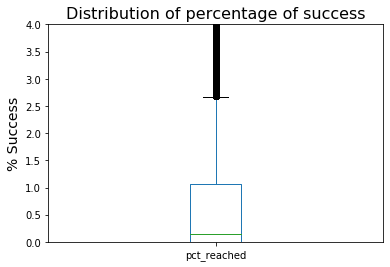

In [17]:
ax = df["pct_reached"].plot(kind="box", ylim=(0,4))
ax.set_title("Distribution of percentage of success", size=16)
ax.set_ylabel("% Success", size=14)

In [18]:
df["pct_reached"].sort_values().tail(10)

164449     16970.86
15288      22603.00
290936     23036.07
369214     24675.00
285408     27588.23
81368      32843.00
76290      41535.01
360721     55266.57
186096     68764.10
369176    104277.89
Name: pct_reached, dtype: float64

In [19]:
df[df["pct_reached"] > 2.7].shape[0]

17496

Close to a third of all projects are either related to the movie or the music industry.

Text(0, 0.5, 'Category')

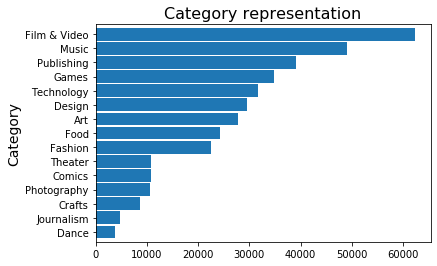

In [20]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Category representation", size=16)
ax.set_ylabel("Category", size=14)

In [21]:
print("Percentage of projects in the film and music industries:", (df_main_cat.iloc[-1] + df_main_cat.iloc[-2]) / df.shape[0] * 100)

Percentage of projects in the film and music industries: 30.076252164259532


Non surprisingly, Kickstarter being first and foremost an English-speaking platform, the top 3 most represented countries are the US (by a large margin), the UK and Canada. Then come German and French countries.

Text(0, 0.5, '')

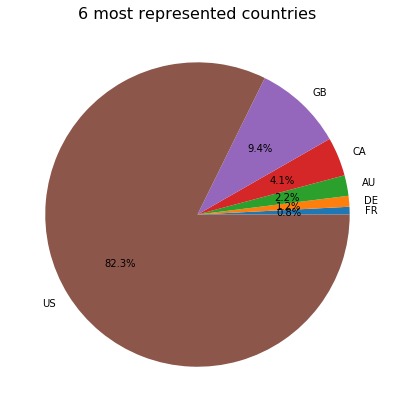

In [22]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(6).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("6 most represented countries", size=16)
ax.set_ylabel("")

# EDA BAKERS
Analyse des bakers selon plusieurs paramètre:</br>


1.   Quantité de bakers selon les statuts finaux (mean, max, min, median, mode)
2.   Quantité de bakers selon le type de projet (mean, max, min, median, mode)
3.   Quantité de bakers selon le pays (mean, max, min, median, mode)
4.   etc....




## Bakers selon le statut final


In [0]:
df1_statut_complet = df1.groupby(['state'])['backers'].agg(['mean','min','max','median',lambda x: x.mode()[0]])
df1_statut_complet

,mean,min,max,median,<lambda_0>
state,,,,,
canceled,25.987390,0,9326,3,0
failed,16.422352,0,6550,3,0
successful,263.921362,0,219382,71,19


## Bakers selon la main_category


In [0]:
df1_type_complet = df1.groupby(['main_category'])['backers'].agg(['mean','min','max','median',lambda x: x.mode()[0]])
df1_type_complet

,mean,min,max,median,<lambda_0>
main_category,,,,,
Art,42.378925,0,22834,10,0
Comics,135.629198,0,14952,40,0
Crafts,27.629258,0,12705,3,0
Dance,43.097430,0,4133,27,0
Design,241.593576,0,154926,29,0
Fashion,61.901226,0,15129,5,0
Film & Video,67.286889,0,91585,12,0
Food,54.403833,0,13116,6,0
Games,325.569622,0,219382,30,0


##Baker en fonction de:

différents paramètre

UFuncTypeError: ignored

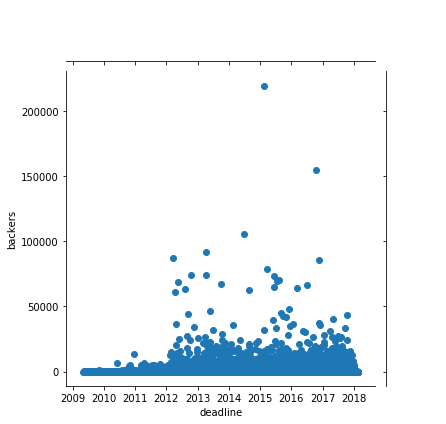

In [0]:
#dfdate =df1[df1["deadline"]>"2005-10-09"]
sns.jointplot(x="deadline", y="backers", data=df1[df1["deadline"]>"2005-10-09"]);

In [0]:

sns.jointplot(x="usd pledged", y="backers", data=df1[df1["usd pledged"]<5000]);

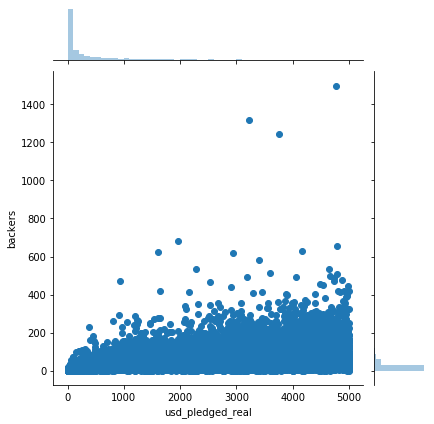

In [0]:

sns.jointplot(x="usd_pledged_real", y="backers", data=df1[df1["usd_pledged_real"]<5000]);

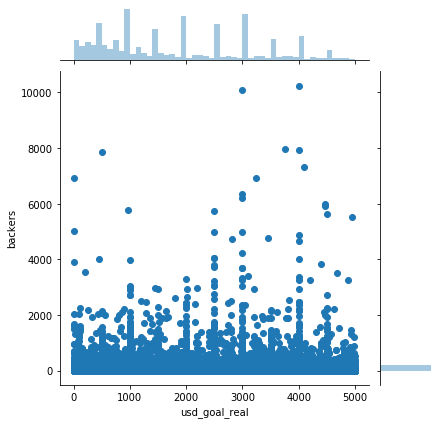

In [0]:
sns.jointplot(x="usd_goal_real", y="backers", data=df1[df1["usd_goal_real"]<5000]);